In [ ]:
import PIL.Image
from PIL import Image, ImageTk
from typing import Tuple
from tkinter import *
import cv2
import numpy as np

In [27]:
from main import *
%reload_ext main

scale = 1
stride = 3
margin = 40

video = cv2.VideoCapture("videos/bee_240.mp4")

_, first_frame = video.read()
first_frame = preprocess_frame(first_frame, scale=scale)
while True:
    selected_box = SelectBoxWindow.show_and_get_box(first_frame)
    if selected_box[-1] != 0 and selected_box[-2] != 0:
        break
print(selected_box)
tracker = ObjectTracker(first_frame, selected_box,
                        stride=stride, margin=margin, coords_mem_size=5, 
                        sigma=2, first_last_ratio=[0.25, 0.75])
show_tracking_animation(video, tracker, scale=scale, thickness=3)
# np.asarray(tracker.coords_all)


(720, 1280, 3)
(319, 25, 100, 65)


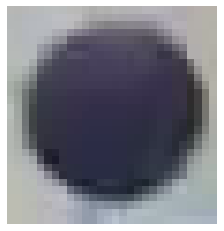

209 760 31 23
206 751 31 19
203 739 31 18
200 726 33 19
199 714 33 18
198 701 34 20
198 690 34 21
198 679 28 11
193 661 192 656
311 1126 351 1283
554 2084 628 2375
1010 3907 1148 4459
1891 7331 2158 8366
3548 13755 4049 15697
6657 25809 7597 29452
12491 48426 14254 55261
23437 90863 26745 103687
43975 170489 50182 194550
82512 319892 94157 365039
154819 600222 176669 684931
290491 1126211 331488 1285153
545055 2113138 621979 2411364
1022701 3964933 1167034 4524502
1918919 7439503 2189735 8489435
3600515 13958925 4108654 15928938
6755736 26191478 7709169 29887863
12675956 49143723 14464905 56079341
23784212 92209592 27140861 105223064
44626910 173015154 50925073 197432656
83734582 324632643 95551983 370447810
157113283 609116315 179286565 695080453


In [26]:
import collections
import pytictoc
from main import *
from matplotlib import pyplot as plt
from typing import Tuple
from skimage import morphology
%reload_ext main

timer = pytictoc.TicToc()

scale = 1
stride = 4
margin = 40

video = cv2.VideoCapture("videos/basketball_1.mp4")


def get_keypoints(img: np.ndarray, nfeatures=40, nOctaveLayers: int = 3, sigma: float = 1.5):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create(nfeatures, nOctaveLayers, sigma=sigma)
    kp, dsc = sift.detectAndCompute(gray, None)
    return kp, dsc, gray


def center_of_mass_match(img1: np.ndarray, img2: np.ndarray, cv2_norm: int = cv2.NORM_L1, nfeatures=40, nOctaveLayers: int = 3, sigma: float = 1.5, def_yx=(-1, -1)):
    try:
        kp1, dsc1, gray1 = get_keypoints(img1, nfeatures, nOctaveLayers, sigma)
        kp2, dsc2, gray2 = get_keypoints(img2, nfeatures, nOctaveLayers, sigma)
        bf = cv2.BFMatcher(cv2_norm, crossCheck=True)
        matches = bf.match(dsc1, dsc2)
        indexes = np.asarray(
            [kp2[m.trainIdx].pt for m in matches], dtype='int')
        if len(indexes):
            x, y = np.mean(indexes, axis=0, dtype='int')
            return y, x
    except:
        pass
    # Match not found
    return def_yx


def connect_images(frame: np.ndarray, track_window: Tuple[int, int], img1: np.ndarray, img2: np.ndarray, cv2_norm: int = cv2.NORM_L1, nfeatures=40, nOctaveLayers: int = 3, sigma: float = 1.5):
    # , nfeatures, nOctaveLayers, sigma)
    kp1, dsc1, gray1 = get_keypoints(img1)
    # , nfeatures, nOctaveLayers, sigma)
    kp2, dsc2, gray2 = get_keypoints(img2)
    bf = cv2.BFMatcher(cv2_norm, crossCheck=True)
    matches = bf.match(dsc1, dsc2)
    matches = sorted(matches, key=lambda x: x.distance)

    img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches, img2, flags=2)
    plt.imshow(img3)
    plt.axis('off')
    plt.show()
    indexes = np.asarray(
        [kp2[m.trainIdx].pt for m in matches], dtype='int')[..., ::-1]

    indexes[..., 0] += track_window[0] - (img2.shape[0] - img1.shape[0]) // 2
    indexes[..., 1] += track_window[1] - (img2.shape[1] - img1.shape[1]) // 2

    term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)

    # img4 = np.zeros(frame.shape[:2])
    img4 = np.copy(frame)
    dst = np.zeros(frame.shape[:2])

    disk = morphology.disk(25)[..., np.newaxis] * 255.0
    disk = np.repeat(disk, 3, axis=-1)
    dy, dx = np.asarray(disk.shape[:2]) // 2

    for index in indexes:
        y, x = index
        # img4[y-dy:y+dy+1, x-dx:x+dx+1] = disk
        # dst[y-dy:y+dy+1, x-dx:x+dx+1] += disk[..., 0]
        dst[y, x] = 1

    dst /= np.max(dst)
    _, track_window = cv2.meanShift(dst, track_window, term_crit)

    # plt.figure(figsize=(24, 16))
    # plt.imshow(dst, 'gray')
    # plt.axis('off')
    # plt.show()

    return track_window
    plt.figure(figsize=(24, 16))
    plt.imshow(img4)
    plt.axis('off')
    plt.show()


_, img = video.read()
margin = 20
nfeatures = 5
nOctaveLayers = 3
sigma = 1.5


y, x, w, h = (209, 760, 28, 29)
# y, x, w, h = (324, 197, 38, 36)
# y, x, w, h = (363, 836, 108, 246)
height, width, _ = img.shape

plt.imshow(img[y:y+h, x:x+w])
plt.axis('off')
plt.show()


mem_len = 3
mem = collections.deque([(y, x) for _ in range(mem_len)], maxlen=mem_len)
weights = np.arange(1, mem_len + 1) ** 3
weights = weights / np.sum(weights)

for i in range(600):
    ret, nimg = video.read()
    if ret == False:
        break

    part1 = img[y:y+h, x:x+w]
    part2 = nimg[y-margin:y+h+margin, x-margin:x+w+margin]

    cy, cx = center_of_mass_match(
        part1, part2, nfeatures=nfeatures, nOctaveLayers=nOctaveLayers, sigma=sigma, def_yx=mem[-1])

    print(y, x, cy, cx)
    _y, _x = cy + y - part2.shape[0] // 2, cx + x - part2.shape[1] // 2
    #ny, nx = min(max(0, _y), height - h), min(max(0, _x), width - w)
    ny, nx = _y, _x
    mem.append((ny, nx))

    avg_y, avg_x = np.average(mem, axis=0, weights=weights)
    y, x = int(avg_y), int(avg_x)

    
    frame = cv2.rectangle(np.copy(nimg), (x, y),
                          (x+w, y+h), (0, 0, 255), thickness=3)
    if False:
        frame[y, x] = (255, 255, 255)
        plt.figure(figsize=(24, 16))
        plt.imshow(frame)
        plt.axis('off')
        plt.show()
    else:
        cv2.imshow('frame', frame)
    # Press Q on keyboard to  exit
    if cv2.waitKey(25) & 0xFF == ord("q"):
        cv2.destroyAllWindows()
        break

    img = nimg
cv2.destroyAllWindows()
cv2.waitKey(1)
video.release()
